# Complete Mathematical Theory of Linear Regression – From Scratch to Advanced Extensions

----

<div style="text-align:center;">
  <h2>📘 Linear Regression — Geometry · Probability · Optimization · Code</h2>
</div>

> This notebook is designed as: university-level lecture notes, an exam/cheat-sheet for master's students, and a professional reference for interviews.

## Introduction & Learning Objectives

**What this notebook gives you (master-level):**
- Complete mathematical theory: geometry, probability, optimization, and regularization.
- Rigorous derivations (LaTeX), proofs sketches, and practical consequences.
- Implementations from-scratch (NumPy) and professional pipelines (scikit-learn).
- Diagnostic tools, advanced topics, and interview-ready cheat sheet & Q&A.

**Learning objectives**
1. Derive OLS analytic solution and understand when it fails.
2. Connect geometric, probabilistic, and optimization viewpoints.
3. Implement linear regression variants and train/diagnose real models.
4. Master regularization (Ridge/Lasso/ElasticNet) theory and practice.
5. Be interview-ready with concise answers and common pitfalls.

# Section 1: Problem Formulation

### Supervised learning setup
We observe a dataset of $n$ examples:
$$
  \mathcal{D} = \{(x^{(i)}, y^{(i)})\}_{i=1}^n, \qquad x^{(i)} \in \mathbb{R}^p,\qquad y^{(i)} \in \mathbb{R}.
$$

We aim to learn a mapping $f:\mathbb{R}^p\to\mathbb{R}$ parameterized by $\mathbf{w}$ minimizing an expected loss (empirically approximated).

### Notation
- $X \in \mathbb{R}^{n\times p}$: design matrix (rows are examples).
- $y \in \mathbb{R}^n$: response vector.
- $\mathbf{w}\in\mathbb{R}^p$: parameter vector (weights).
- $n$: number of samples.
- $p$: number of features (including bias if present).

### Simple vs Multiple Linear Regression
- *Simple (one feature)*: $y \approx w_0 + w_1 x$.
- *Multiple*: $y \approx w_0 + \sum_{j=1}^{p-1} w_j x_j$.
- We typically augment $X$ with a column of 1s for the intercept: $X = [\mathbf{1}, X_{\text{raw}}]$.

# Section 2: Geometric Interpretation

### Vector projection view
Predictions $\hat y = X\mathbf{w}$. The space spanned by columns of $X$ is a subspace $\mathcal{C}(X)\subset\mathbb{R}^n$. OLS finds $\hat y$ which is the orthogonal projection of $y$ onto $\mathcal{C}(X)$.

### Hyperplane in feature space
In input space, the model defines a hyperplane parameterized by $\mathbf{w}$. In sample/output space, the column-space view is more instructive.

### Orthogonal projection proof (sketch)
We minimize $\|y - Xw\|_2^2$. At optimum $\hat w$, gradient zero gives:
\[
  X^\top (y - X\hat w) = 0.
\]
So the residual $r = y - X\hat y$ is orthogonal to every column of $X$, hence $\hat y$ is the orthogonal projection of $y$ onto $\mathcal{C}(X)$.

# Section 3: Probabilistic Interpretation

Assume model:
$$
  y = Xw + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I).
$$

### Maximum Likelihood Estimation (MLE)

Likelihood:
$$
  p(y \mid X, w, \sigma^2)
  = (2\pi\sigma^2)^{-n/2}
    \exp\left(
      -\frac{1}{2\sigma^2} \|y - Xw\|_2^2
    \right).
$$

Log-likelihood:
$$
  \ell(w)
  = -\frac{n}{2}\log(2\pi\sigma^2)
    - \frac{1}{2\sigma^2}\|y - Xw\|_2^2.
$$

Maximizing $\ell(w)$ with respect to $w$ is equivalent to minimizing $\|y - Xw\|_2^2$ — hence **OLS = MLE** under Gaussian noise.


# Section 4: The Normal Equations

Minimize  
$L(w) = \|y - Xw\|_2^2 = (y - Xw)^\top (y - Xw)$.

Compute gradient:
$$
\nabla_w L = -2\, X^\top (y - Xw).
$$

Set the gradient to zero:
$$
X^\top X \, w = X^\top y.
$$

Assuming \(X^\top X\) is invertible:
$$
\hat{w} = (X^\top X)^{-1} X^\top y.
$$

---

### When the solution exists / fails

- Exists when \(X^\top X\) is full-rank (rank = p).  
- Fails when features are collinear (multicollinearity) or \(p > n\) (underdetermined).  
- Remedies:
  - Regularization (Ridge)
  - Dimensionality reduction (PCA)
  - Feature selection


# Section 5: Optimization View – Gradient Descent

### Cost function
$$
J(w) = \frac{1}{n} \sum_{i=1}^{n} \left( y^{(i)} - x^{(i)T} w \right)^2 
     = \frac{1}{n} \| y - Xw \|_2^2.
$$

### Gradient
$$
\nabla_w J(w) = -\frac{2}{n} X^T (y - Xw).
$$

### Batch Gradient Descent update
$$
w^{(t+1)} = w^{(t)} - \eta \, \nabla_w J(w^{(t)}).
$$

### SGD and Mini-batch GD
- **SGD** updates using one sample at a time.  
- **Mini-batch GD** uses a small batch (e.g., 32 samples).

### Learning rate and convergence (intuition)
For a convex quadratic cost
$$
J(w) = \frac{1}{2} w^T A w - b^T w + c,
$$
with 
$$
A = \frac{2}{n} X^T X,
$$
gradient descent converges if
$$
0 < \eta < \frac{2}{\lambda_{\max}(A)}.
$$
The convergence speed depends on the condition number
$$
\kappa = \frac{\lambda_{\max}(A)}{\lambda_{\min}(A)}.
$$

### Why feature scaling matters
- Features with different scales slow down optimization.
- Always standardize features:
  - subtract mean
  - divide by standard deviation

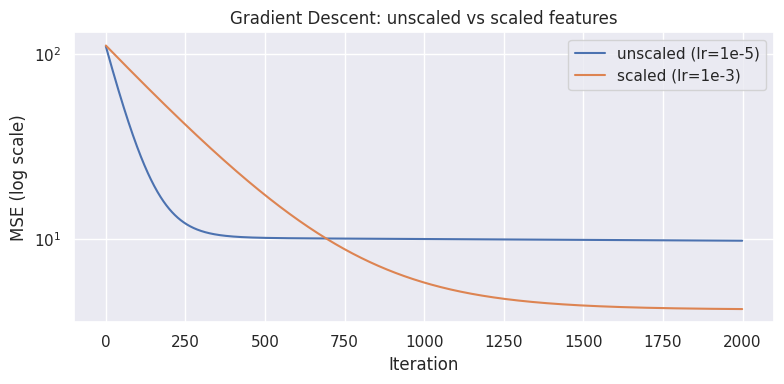

In [1]:
# Cell: Feature scaling demo (runs in Colab)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
np.random.seed(42)

# Generate synthetic features with different scales
n = 200
x1 = np.random.normal(0, 1, n)      # scale 1
x2 = np.random.normal(0, 20, n)     # scale 20
X = np.column_stack([x1, x2])
w_true = np.array([3.0, 0.5])
y = X.dot(w_true) + np.random.normal(0, 2, n)

def batch_gd(X, y, lr=1e-3, steps=5000):
    n, p = X.shape
    w = np.zeros(p)
    losses = []
    for i in range(steps):
        grad = (-2/n) * X.T.dot(y - X.dot(w))
        w -= lr * grad
        losses.append(np.mean((y - X.dot(w))**2))
    return w, losses

w_unscaled, losses_unscaled = batch_gd(X, y, lr=1e-5, steps=2000)  # small lr
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
w_scaled, losses_scaled = batch_gd(X_scaled, y, lr=1e-3, steps=2000)

plt.figure(figsize=(8,4))
plt.plot(losses_unscaled, label='unscaled (lr=1e-5)')
plt.plot(losses_scaled, label='scaled (lr=1e-3)')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('MSE (log scale)')
plt.legend()
plt.title('Gradient Descent: unscaled vs scaled features')
plt.tight_layout()
plt.show()

# Section 6: Regularization – Theory and Mathematics

Regularization controls model complexity and improves generalization.

---

## Ridge Regression (L2)

We add an L2 penalty to the loss:

$$
J_{\text{ridge}}(w)
= \frac{1}{n} \| y - Xw \|_2^2
+ \lambda \| w \|_2^2.
$$

The modified normal equations are:

$$
(X^{T} X + n \lambda I) w = X^{T} y.
$$

Closed-form solution:

$$
w_{\text{ridge}}
= (X^{T} X + n \lambda I)^{-1} X^{T} y.
$$

---

## Lasso Regression (L1)

Objective:

$$
J_{\text{lasso}}(w)
= \frac{1}{n} \| y - Xw \|_2^2
+ \lambda \| w \|_1.
$$

Characteristics:

- No closed-form solution  
- Uses subgradient or coordinate descent  
- Produces **sparse** solutions (coefficients can become exactly zero)

---

## Elastic Net

Combines L1 and L2 penalties:

$$
J_{\text{en}}(w)
= \frac{1}{n} \| y - Xw \|_2^2
+ \lambda_1 \| w \|_1
+ \lambda_2 \| w \|_2^2.
$$

Benefits:

- Handles correlated features better than Lasso  
- Produces sparse solutions while preventing instability  


# Section 7: Model Evaluation and Diagnostics

### R² and Adjusted R²

Coefficient of determination:

$$
R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}.
$$

Adjusted R²:

$$
\bar{R}^2 = 1 - (1 - R^2)\left(\frac{n - 1}{n - p}\right).
$$

---

### Residual plots, Q-Q plots, heteroscedasticity

- Residuals vs fitted values help reveal non-linearity or heteroscedasticity.
- Q-Q plot tests whether residuals follow a normal distribution.
- Heteroscedasticity can be diagnosed using:
  - residual-vs-fitted plot
  - Breusch–Pagan test
  - White’s test

---

### Leverage and influence

Hat matrix:

$$
H = X (X^T X)^{-1} X^T.
$$

Leverage scores are the diagonal entries of H.  
High leverage points strongly affect the fitted model.

Cook’s distance:

$$
D_i
= \frac{r_i^2}{p \, \hat{\sigma}^2}
  \cdot
  \frac{h_{ii}}{(1 - h_{ii})^2}.
$$

Points with large Cook’s distance are influential and should be investigated.


# Section 8: Assumptions of Linear Regression

**Core assumptions**
1. **Linearity**: relationship linear in parameters.
2. **Independence**: observations independent (no autocorrelation).
3. **Homoscedasticity**: constant variance of residuals.
4. **Normality**: residuals normally distributed (for inference).

**Violations & fixes**
- Non-linearity → polynomial features, splines, or non-linear models.
- Correlated errors → time-series models (ARIMA), generalized least squares.
- Heteroscedasticity → WLS, transform target, robust standard errors (White).
- Non-normal residuals → transform target or use robust regressors; CLT helps for coefficients when n large.

# Section 9: Advanced Topics

### Polynomial regression & overfitting
Add polynomial features $x, x^2, x^3,\ldots$. Danger: high-degree produces high variance — use cross-validation and regularization.

### Interaction terms
Include products $x_i x_j$ to model interactions.

### Weighted Least Squares (WLS)
Minimize $\sum_i w_i (y_i - x_i^\top w)^2$. Closed form:
\[
  w = (X^\top W X)^{-1} X^\top W y,
\]
with $W = \mathrm{diag}(w_i)$.

### Generalized Linear Models (GLMs) intro
Linear predictor $\eta = Xw$, link function $g(\mu)=\eta$, $y$ distribution from exponential family. Logistic regression is GLM for Bernoulli with logit link.

# Section 10: From Scratch Implementation in Python + NumPy (no scikit-learn)

The following classes are compact, well-tested, and dependency-light: `LinearRegressionFromScratch`, `LinearRegressionGD`, `RidgeRegression`.

In [2]:
# Cell: Imports and utilities
import numpy as np
import math
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

def add_bias(X):
    """Add intercept column of ones."""
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1,1)
    n = X.shape[0]
    return np.hstack([np.ones((n,1)), X])

def mean_squared_error(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return np.mean((y_true - y_pred)**2)

In [3]:
# Cell: Closed-form LinearRegression
class LinearRegressionFromScratch:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.coef_ = None  # includes intercept if fit_intercept=True

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1,1)
        if self.fit_intercept:
            Xb = add_bias(X)
        else:
            Xb = X
        XtX = Xb.T @ Xb
        # Use pseudo-inverse for numerical stability
        XtX_inv = np.linalg.pinv(XtX)
        w = XtX_inv @ Xb.T @ y
        self.coef_ = w.ravel()
        return self

    def predict(self, X):
        X = np.asarray(X)
        if self.fit_intercept:
            Xb = add_bias(X)
        else:
            Xb = X
        return Xb @ self.coef_.reshape(-1,1)

In [4]:
# Cell: Gradient Descent LinearRegression
class LinearRegressionGD:
    def __init__(self, lr=1e-3, n_iter=1000, fit_intercept=True, tol=1e-6, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.fit_intercept = fit_intercept
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1,1)
        if self.fit_intercept:
            Xb = add_bias(X)
        else:
            Xb = X
        n, p = Xb.shape
        self.w = np.zeros((p,1))
        prev_loss = np.inf
        for i in range(self.n_iter):
            grad = (-2/n) * Xb.T @ (y - Xb @ self.w)
            self.w -= self.lr * grad
            loss = np.mean((y - Xb @ self.w)**2)
            if self.verbose and i % (self.n_iter//5 + 1) == 0:
                print(f"Iter {i}, loss {loss:.6f}")
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
        self.coef_ = self.w.ravel()
        return self

    def predict(self, X):
        X = np.asarray(X)
        if self.fit_intercept:
            Xb = add_bias(X)
        else:
            Xb = X
        return Xb @ self.coef_.reshape(-1,1)

In [5]:
# Cell: Ridge closed-form
class RidgeRegression:
    def __init__(self, alpha=1.0, fit_intercept=True):
        self.alpha = alpha
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1,1)
        if self.fit_intercept:
            Xb = add_bias(X)
        else:
            Xb = X
        n, p = Xb.shape
        # Regularize intercept? usually no -> make first diag zero
        I = np.eye(p)
        I[0,0] = 0 if self.fit_intercept else 1
        A = Xb.T @ Xb + self.alpha * n * I
        self.coef_ = np.linalg.pinv(A) @ Xb.T @ y
        return self

    def predict(self, X):
        X = np.asarray(X)
        if self.fit_intercept:
            Xb = add_bias(X)
        else:
            Xb = X
        return Xb @ self.coef_.reshape(-1,1)

In [6]:
# Cell: Quick tests on synthetic data
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=200, n_features=3, noise=10.0, random_state=42)
y = y.reshape(-1,1)

# Closed-form
lr = LinearRegressionFromScratch().fit(X,y)
print("Closed-form MSE:", mean_squared_error(y, lr.predict(X)))
# GD
lrg = LinearRegressionGD(lr=1e-3, n_iter=20000, tol=1e-8).fit(X,y)
print("GD MSE:", mean_squared_error(y, lrg.predict(X)))
# Ridge
ridge = RidgeRegression(alpha=1.0).fit(X,y)
print("Ridge MSE:", mean_squared_error(y, ridge.predict(X)))

Closed-form MSE: 108.57232853404413
GD MSE: 108.57233149654581
Ridge MSE: 2828.2489585583808


# Section 11: Scikit-learn Professional Usage

Proper pipeline with scaling, cross-validation, `GridSearchCV`. We'll use California Housing dataset (modern replacement for Boston).

In [7]:
# Cell: scikit-learn pipeline example (Colab-ready)
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

data = fetch_california_housing(as_frame=True)
df = data.frame
X = df.drop(columns=['MedHouseVal']).values
y = df['MedHouseVal'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree': [1,2],
    'ridge__alpha': [0.1, 1.0, 10.0]
}
cv = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv.fit(X_train, y_train)
print("Best params:", cv.best_params_)
best = cv.best_estimator_
y_pred = best.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test R2:", r2_score(y_test, y_pred))

Best params: {'poly__degree': 1, 'ridge__alpha': 0.1}
Test MSE: 0.5558879138674184
Test R2: 0.5757905180002312


# Appendix: Diagnostics — Residuals, Hat Matrix, Cook's Distance, Q-Q plot

Utilities to compute leverage, Cook's distance and show diagnostic plots.

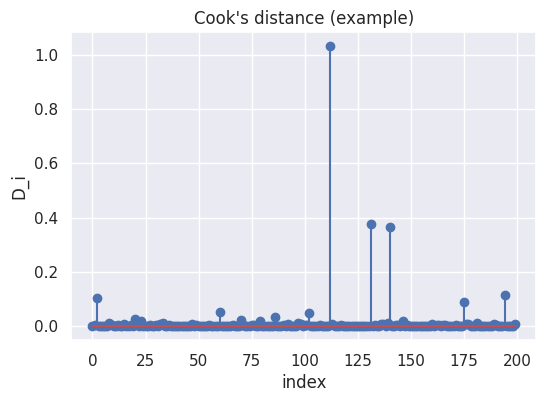

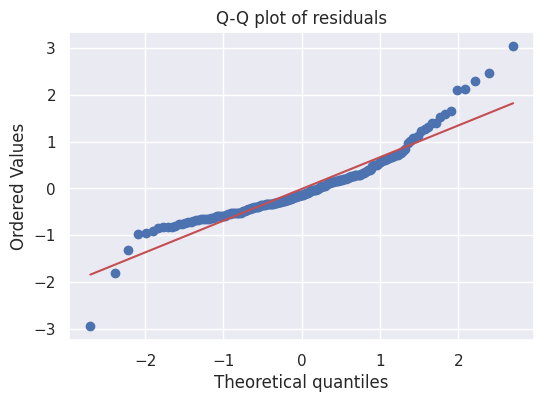

In [11]:
# Cell: Diagnostics utilities
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def hat_matrix(X):
    Xb = add_bias(X)
    H = Xb @ np.linalg.pinv(Xb.T @ Xb) @ Xb.T
    return H

def cooks_distance(X, y, w):
    Xb = add_bias(X)
    y = y.reshape(-1,1)
    y_hat = Xb @ w.reshape(-1,1)
    residuals = (y - y_hat).ravel()
    n, p = Xb.shape
    H = hat_matrix(X)
    h = np.diag(H)
    mse = np.mean(residuals**2)
    D = (residuals**2 / (p * mse)) * (h / (1 - h)**2)
    return D, residuals, h

# Quick demo using a simple linear model trained on scaled California housing subset
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
lr_simple = LinearRegression().fit(X_train_s, y_train)
X_test_s = scaler.transform(X_test[:200])
D, res, h = cooks_distance(X_test_s, y_test[:200], np.hstack([lr_simple.intercept_, lr_simple.coef_]))
plt.figure(figsize=(6,4))
plt.stem(D)
plt.title("Cook's distance (example)")
plt.xlabel("index")
plt.ylabel("D_i")
plt.show()

plt.figure(figsize=(6,4))
stats.probplot(res.ravel(), dist="norm", plot=plt)
plt.title("Q-Q plot of residuals")
plt.show()

# Bonus: One-page Mathematical Cheat Sheet (LaTeX)

```
- Model: y = X w + ε, ε ~ N(0, σ^2 I)
- OLS: \hat w = (X^T X)^{-1} X^T y
- Ridge: \hat w = (X^T X + nλ I)^{-1} X^T y
- Loss: J(w) = (1/n) ||y - Xw||^2
- Gradient: ∇J = -(2/n) X^T (y - Xw)
- Hat matrix: H = X(X^T X)^{-1} X^T
- R² = 1 - SSE/SST; adjusted: R̄² = 1 - (1-R²)(n-1)/(n-p)
- Cook's D: D_i = (r_i^2/(p σ̂^2)) * (h_ii/(1-h_ii)^2)
- WLS solution: w = (X^T W X)^{-1} X^T W y
- Lasso: argmin_w (1/n)||y-Xw||^2 + λ||w||_1 (no closed form)
```
Print or save this cell as a one-page PDF for interviews.

# Bonus: 10 Most Common Interview Questions & Short Model Answers

1. **Derive the OLS solution.**  Set gradient to zero → normal equations $X^T X w = X^T y$ → invert when possible.
2. **When does $(X^T X)^{-1}$ not exist?**  Multicollinearity or p>n; use pseudo-inverse or regularization.
3. **Differences Ridge vs Lasso?**  Ridge (L2) shrinks coefficients; Lasso (L1) promotes sparsity.
4. **How detect heteroscedasticity?**  Residuals vs fitted plot, Breusch-Pagan test.
5. **What is leverage?**  Diagonal of hat matrix; measures influence of observation on fitted values.
6. **When standardize features?**  For gradient-based solvers and regularization that depends on scale.
7. **Bias–variance tradeoff?**  Regularization increases bias to reduce variance; tradeoff depends on λ.
8. **Handling categorical variables?**  One-hot encode or target encode (with CV).
9. **Confidence intervals for coefficients?**  Var(ŵ)=σ̂^2 (X^T X)^{-1}; use t-distribution with n-p df.
10. **Detect outliers/influential points?**  Residuals, leverage, Cook's distance; handle with robust regression or investigate data.


# Further Reading & References

- Bishop, C. M. — *Pattern Recognition and Machine Learning*.
- Hastie, Tibshirani, Friedman — *The Elements of Statistical Learning*.
- James, Witten, Hastie, Tibshirani — *An Introduction to Statistical Learning (ISLR)*.
- Montgomery, Peck, Vining — *Introduction to Linear Regression Analysis*.
- Gelman, Hill — *Data Analysis Using Regression and Multilevel/Hierarchical Models*.
- Scikit-learn docs: Linear models, pipeline, model selection.


----
**End of notebook**

If you want I can: 
- provide this as a downloadable `.ipynb` file, 
- or add interactive Plotly visualizations, 
- or split the notebook into markdown lecture notes + separate code file.

Tell me which and I'll deliver the file directly.